# Step 1: Install and Import Libraries

In [188]:
!pip install pandas
!pip install geopandas
!pip install folium
!pip install osmnx
!pip install branca
!pip install matplotlib

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
import folium
import osmnx as ox
from branca.colormap import LinearColormap


# Step 2: Load the Data

In [195]:
# Load the data
file_path = '2023 Sold-Rented Real Estate in Palm Beach DataMaster_CSV.xlsx'
data = pd.read_excel(file_path)

# Preview the data
rows, columns = data.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

print(data.head())
print(data.info())


Number of rows: 6600
Number of columns: 80
  MLS NUMBER       STATUS             ADDRESS  BEDS  FBATHS  HBATHS  \
0  R10921162  Closed Sale  14412 Pierson Road     4       6    1.00   
1  R10921659  Closed Sale    156 Seagate Road     4       4    1.00   
2  R10932357  Closed Sale      71 Curlew Road     6       7    2.00   
3  A11470371  Closed Sale      115 Regatta Dr     5       5    2.00   
4  R10927974  Closed Sale   115 Regatta Drive     5       5    2.00   

   LIST PRICE  SOLD PRICE   CONTRACT    SETTLED  ... EXPIRATION DATE  \
0 18000000.00 17300000.00 2023-09-19 2023-12-29  ...      2024-07-01   
1 16995000.00 15250700.00 2023-09-21 2023-11-30  ...      2024-09-24   
2 16399000.00 13903000.00 2023-11-01 2023-12-15  ...      2024-06-30   
3 13500000.00 13250000.00 2023-11-13 2023-11-28  ...      2024-10-31   
4 13500000.00 13250000.00 2023-10-16 2023-11-28  ...      2024-10-31   

  PENDING DATE  OFF MARKET DATE  SALE TERMS  DAYS ON MARKET      COUNTY  \
0   2023-11-24       2

# Step 3: Data Cleaning and Preprocessing

In [198]:
# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Drop rows with missing values in essential columns
relevant_columns = ['LIST PRICE', 'SOLD PRICE', 'BEDS', 'FBATHS', 'TOT SQFT', 'LOT SIZE', 'YEAR BUILT', 'POOL1', 'ADDRESS']
data = data.dropna(subset=relevant_columns)

# Ensure numerical columns are numeric
for col in ['LIST PRICE', 'SOLD PRICE', 'BEDS', 'FBATHS', 'TOT SQFT', 'LOT SIZE', 'YEAR BUILT']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculate Price Difference
data['Price_Difference'] = data['LIST PRICE'] - data['SOLD PRICE']

# If 'POOL1' is not a string, convert it to string
data['POOL1'] = data['POOL1'].astype(str)

# Now create the 'POOL' column based on whether 'POOL1' contains 'Yes'
data['POOL'] = np.where(data['POOL1'].str.contains('Yes', na=False), 1, 0)

# Handle location by extracting ZIP Code or similar feature
if 'ZIP CODE' in data.columns:
    data['ZIP CODE'] = pd.to_numeric(data['ZIP CODE'], errors='coerce')
else:
    data['ZIP CODE'] = data['ADDRESS'].str.extract(r'(\d{5})').astype(float)

# Drop rows with NaN values in the new features
data = data.dropna(subset=['Price_Difference', 'ZIP CODE'])

# Drop duplicates
data = data.drop_duplicates()

print(data.head())


  MLS NUMBER       STATUS             ADDRESS  BEDS  FBATHS  HBATHS  \
0  R10921162  Closed Sale  14412 Pierson Road     4       6    1.00   
2  R10932357  Closed Sale      71 Curlew Road     6       7    2.00   
3  A11470371  Closed Sale      115 Regatta Dr     5       5    2.00   
4  R10927974  Closed Sale   115 Regatta Drive     5       5    2.00   
5  R10925342  Closed Sale   271 La Puerta Way     6       7    1.00   

   LIST PRICE  SOLD PRICE   CONTRACT    SETTLED  ... OFF MARKET DATE  \
0 18000000.00 17300000.00 2023-09-19 2023-12-29  ...      2023-11-24   
2 16399000.00 13903000.00 2023-11-01 2023-12-15  ...      2023-12-08   
3 13500000.00 13250000.00 2023-11-13 2023-11-28  ...      2023-11-13   
4 13500000.00 13250000.00 2023-10-16 2023-11-28  ...      2023-11-11   
5 14950000.00 13000000.00 2023-10-06 2023-12-18  ...      2023-11-07   

  SALE TERMS  DAYS ON MARKET      COUNTY                APN  \
0       Cash           66.00  Palm Beach  73414420160010000   
2       Cash  

In [204]:
sold_price_stats = data['SOLD PRICE'].describe()
# Print results
print("Descriptive Statistics for SOLD PRICE:")
print(f"Mean: {sold_price_stats['mean']}")
print(f"Median: {data['SOLD PRICE'].median()}")
print(f"Standard Deviation: {data['SOLD PRICE'].std()}")
print(f"Minimum: {sold_price_stats['min']}")
print(f"Maximum: {sold_price_stats['max']}")
print(f"25th Percentile: {sold_price_stats['25%']}")
print(f"75th Percentile: {sold_price_stats['75%']}")

Descriptive Statistics for SOLD PRICE:
Mean: 832836.1912832801
Median: 545700.0
Standard Deviation: 1182434.9116674906
Minimum: 75000.0
Maximum: 17300000.0
25th Percentile: 395000.0
75th Percentile: 799675.0


In [208]:
df = pd.read_excel('2023 Sold-Rented Real Estate in Palm Beach DataMaster_CSV.xlsx')
print(f'Number of rows before cleaning: {len(df)}')

# Identify the indexes of the rows where 'STATUS' is 'Rented'
index_to_drop = df[df['STATUS'] == 'Rented'].index
# Delete the corresponding rows
df = df.drop(index_to_drop)

variables = ['LIST PRICE', 'SOLD PRICE', 'CONTRACT', 'LOT SIZE', 'TOT SQFT', 'LIV SQFT', 'DAYS ON MARKET', 'ZIP CODE', 'BEDS', 'FBATHS', 'HBATHS']
for variable in variables:
    # identify the indices of the rows where 'variable' is null or equal to 0
    index_to_drop = df[(df[variable].isnull()) | (df[variable] == 0)].index
    # Delete the corresponding rows
    df = df.drop(index_to_drop)

variables = ['CITY', 'CONST', 'COMPLEX', 'SALE TERMS', 'POOL1', 'SALE TERMS']
for variable in variables:
    # identify the indices of the rows where 'variable' is null or equal to 0
    index_to_drop = df[(df[variable].isnull())].index
    # Delete the corresponding rows
    df = df.drop(index_to_drop)

# identify the indices of the rows where 'LIST PRICE' is null or equal to 0
index_to_drop = df[(df['YEAR BUILT'] < 1950)].index
# Delete the corresponding rows
df = df.drop(index_to_drop)


df = df.reset_index()

print(f'Number of rows after cleaning: {len(df)}')

Number of rows before cleaning: 6600
Number of rows after cleaning: 486


In [210]:
# Difference between list price and sold price
df['DIFFERENCE']            = df['SOLD PRICE'] - df['LIST PRICE']
# Variables included in the pivot table
fields_of_pivot_table       = ['MLS NUMBER', 'CITY', 'ZIP CODE', 'CONST', 'COMPLEX', 'LIV SQFT', 'BEDS', 'FBATHS', 'HBATHS', 'LOT SIZE', 'TOT SQFT', 'YEAR BUILT', 'POOL1', 'DAYS ON MARKET', 'SALE TERMS', 'LIST PRICE', 'SOLD PRICE', 'DIFFERENCE']

fields_of_city_diference    = ['CITY', 'ZIP CODE', 'DIFFERENCE']
# Create pivot table
pivot_table                 = df[fields_of_pivot_table]
# Create 'cities and differences' table
city_diference_table        = df[fields_of_city_diference]


#'AVERAGE DIFFERENCE' by group 'CITY' y 'ZIP CODE'
mean_difference = city_diference_table.groupby(['CITY', 'ZIP CODE'])['DIFFERENCE'].mean().reset_index()

mean_difference = mean_difference.rename(columns={'DIFFERENCE': 'AVERAGE DIFFERENCE'})

#'MEADIAN DIFFERENCE' by group 'CITY' y 'ZIP CODE'
median_difference = city_diference_table.groupby(['CITY', 'ZIP CODE'])['DIFFERENCE'].median().reset_index()

median_difference = median_difference.rename(columns={'DIFFERENCE': 'MEADIAN DIFFERENCE'})

# Count the elements in each group
group_counts = city_diference_table.groupby(['CITY', 'ZIP CODE']).size().reset_index(name='SALES BY CITY')
mean_difference = mean_difference.merge(group_counts, on=['CITY', 'ZIP CODE'])
median_difference = median_difference.merge(group_counts, on=['CITY', 'ZIP CODE'])

# Avoid showing numbers in scientific notation
pd.options.display.float_format = '{:.2f}'.format


# Sort the DataFrame by the 'DIFFERENCE_MEAN' column from highest to lowest
descending_difference_mean  = mean_difference.sort_values(by='AVERAGE DIFFERENCE', ascending=False)
ascending_difference_mean   = mean_difference.sort_values(by='AVERAGE DIFFERENCE', ascending=True)

# Select the first 20 records
descending_difference_mean_20    = descending_difference_mean.head(20)
ascending_difference_mean_20     = ascending_difference_mean.head(20)

# Reset the index of each piece of data to show them in order
descending_difference_mean_20    = descending_difference_mean_20.reset_index(drop=True)
ascending_difference_mean_20     = ascending_difference_mean_20.reset_index(drop=True)

print(ascending_difference_mean_20)

                  CITY  ZIP CODE  AVERAGE DIFFERENCE  SALES BY CITY
0            Manalapan     33462         -2496000.00              1
1           Palm Beach     33480          -607000.00              5
2     North Palm Beach     33408          -500000.00              1
3   Loxahatchee Groves     33470          -349000.00              1
4              Lantana     33462          -249000.00              1
5           Boca Raton     33432          -192500.00              4
6         Delray Beach     33483          -187800.00              5
7              Jupiter     33478          -177733.33              6
8              Jupiter     33477          -177153.85             13
9        Boynton Beach     33473          -170000.00              1
10     West Palm Beach     33412          -161500.00              4
11       Singer Island     33404          -138593.75              2
12          Boca Raton     33496          -137874.94             16
13        Delray Beach     33444          -12500

In [212]:
print(descending_difference_mean_20)

                CITY  ZIP CODE  AVERAGE DIFFERENCE  SALES BY CITY
0          Lake Park     33403            25100.00              1
1      Riviera Beach     33407            10000.00              1
2    West Palm Beach     33417             1168.75              8
3   North Palm Beach     33410                0.00              1
4   Lake Worth Beach     33460                0.00              2
5    West Palm Beach     33413             -225.00              4
6         Greenacres     33463            -1785.71              7
7      Riviera Beach     33404            -2362.50              8
8         Lake Worth     33463            -3875.00              8
9    West Palm Beach     33401            -4500.00             10
10   West Palm Beach     33407            -4542.86              7
11     Boynton Beach     33426            -4862.50              8
12     Riviera Beach     33418            -4900.00              1
13     Riviera Beach     33410            -5724.75              4
14     Boy

## Map to Visualize Cities

In [215]:
# List top 20 cities with highest/lowest difference
cities      = list(descending_difference_mean_20['CITY'])
means       = list(descending_difference_mean_20['AVERAGE DIFFERENCE'])
zip_codes   = list(descending_difference_mean_20['ZIP CODE'])

# Initialize map.
map_folium = folium.Map(location=[26.683325170726004, -80.09381394697488], zoom_start=10)

# Add Google Maps
folium.TileLayer(
    tiles='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(map_folium)

# Format colors (red and white)
colormap = LinearColormap(['red', 'white'], vmin=min(means), vmax=max(means))

# Add city boundaries
for city_name, mean, zip_code in zip(cities, means, zip_codes):
    
    city_boundary = ox.geocode_to_gdf(city_name+f', FL {zip_code}')
    
    if not city_boundary.empty:
      
        color = colormap(mean)

        # Add the polygon to the map
        folium.GeoJson(
            city_boundary.geometry,
            style_function=lambda feature, color=color: {
                'fillColor': color[:-2],  
                'color': 'black',
                'weight': 2,
                'fillOpacity': 0.8
            },
        ).add_to(map_folium)

        # Geometry CRS (UTM)
        city_boundary = city_boundary.to_crs(epsg=3395)  
        
        # City's centroid and marker
        city_center_proj  = city_boundary.geometry.centroid.iloc[0]
      
        city_center_proj_gs = gpd.GeoSeries([city_center_proj], crs='EPSG:3395')
        
        # Geographic coordinates (latitude/longitude)
        city_center = city_center_proj_gs.to_crs(epsg=4326).iloc[0]  # EPSG:4326 is the CRS geographic

        folium.Marker(
            location=[city_center.y, city_center.x],  # latitud, longitud
            popup=f"<span style='font-size:16px'><b>City: </b>{city_name}<br><span style='font-size:16px'><b>Average difference</b>: {mean:.2f}</span>",
            icon=folium.Icon(color=f'darkblue', icon='info-sign')
        ).add_to(map_folium)


# Legend white color using HTML y CSS
legend_html ="""
<div style="position: fixed; 
            top: 5px; right: 10px; width: 460px; height: 50px; 
            background-color: white; opacity: 0.7; z-index: 1000; 
            font-size: 18px; font-weight: bold; color: white; padding: 10px; border-radius: 5px">
</div>"""

# Add legend
map_folium.get_root().html.add_child(folium.Element(legend_html))


colormap.caption = 'Average difference'
colormap.add_to(map_folium)

# Add title with HTML
title_html = '''
             <h1 style="position: fixed; 
                        top: 0px; 
                        left: 250px; 
                        transform: translateX(-50%); 
                        font-size: 24px; 
                        color: white; 
                        font-weight: bold; 
                        z-index: 1000;">20 cities with<br>the highest average difference</h1>
             '''
map_folium.get_root().html.add_child(folium.Element(title_html))

# Show map
map_folium


In [217]:
# Cities/zip codes and averages
cities      = list(descending_difference_mean_20['CITY'])
means       = list(descending_difference_mean_20['AVERAGE DIFFERENCE'])
zip_codes   = list(descending_difference_mean_20['ZIP CODE'])

# Initialize map
map_folium = folium.Map(location=[26.683325170726004, -80.09381394697488], zoom_start=10)

# Add Google Maps
folium.TileLayer(
    tiles='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(map_folium)

# Format colors (red and white)
colormap = LinearColormap(['red', 'white'], vmin=min(means), vmax=max(means))

# Add city boundaries
for city_name, mean, zip_code in zip(cities, means, zip_codes):
    try:
        
        city_boundary = ox.geocode_to_gdf(city_name+f', FL {zip_code}')
        
        if not city_boundary.empty:
        
            color = colormap(mean)

            # Add the polygon to the map
            folium.GeoJson(
                city_boundary.geometry,
                style_function=lambda feature, color=color: {
                    'fillColor': color[:-2],  
                    'color': 'black',
                    'weight': 2,
                    'fillOpacity': 0.8
                },
            ).add_to(map_folium)

            # Geometry CRS (UTM)
            city_boundary = city_boundary.to_crs(epsg=3395)  
            
            # City's centroid and marker
            city_center_proj  = city_boundary.geometry.centroid.iloc[0]
                        
            city_center_proj_gs = gpd.GeoSeries([city_center_proj], crs='EPSG:3395')
            
           # Geographic coordinates (latitude/longitude)
            city_center = city_center_proj_gs.to_crs(epsg=4326).iloc[0]  # EPSG:4326 is the CRS geografic

            folium.Marker(
                location=[city_center.y, city_center.x],  # latitud, longitud
                popup=f"<span style='font-size:16px'><b>City: </b>{city_name}<br><span style='font-size:16px'><b>Average difference</b>: {mean:.2f}</span>",
                icon=folium.Icon(color=f'darkblue', icon='info-sign')
            ).add_to(map_folium)
    except Exception as e:
        print(f"Error geocodificando la ciudad {city_name}: {e}")

# Legend white color using HTML y CSS
legend_html ="""
<div style="position: fixed; 
            top: 5px; right: 10px; width: 460px; height: 50px; 
            background-color: white; opacity: 0.7; z-index: 1000; 
            font-size: 18px; font-weight: bold; color: white; padding: 10px; border-radius: 5px">
</div>"""

# Add legend
map_folium.get_root().html.add_child(folium.Element(legend_html))

colormap.caption = 'Average difference'
colormap.add_to(map_folium)

# Add title with HTML
title_html = '''
             <h1 style="position: fixed; 
                        top: 0px; 
                        left: 250px; 
                        transform: translateX(-50%); 
                        font-size: 24px; 
                        color: white; 
                        font-weight: bold; 
                        z-index: 1000;">20 cities with<br>the lowest average difference</h1>
             '''
map_folium.get_root().html.add_child(folium.Element(title_html))

# Show map
map_folium

# 3. Correlation Matrix

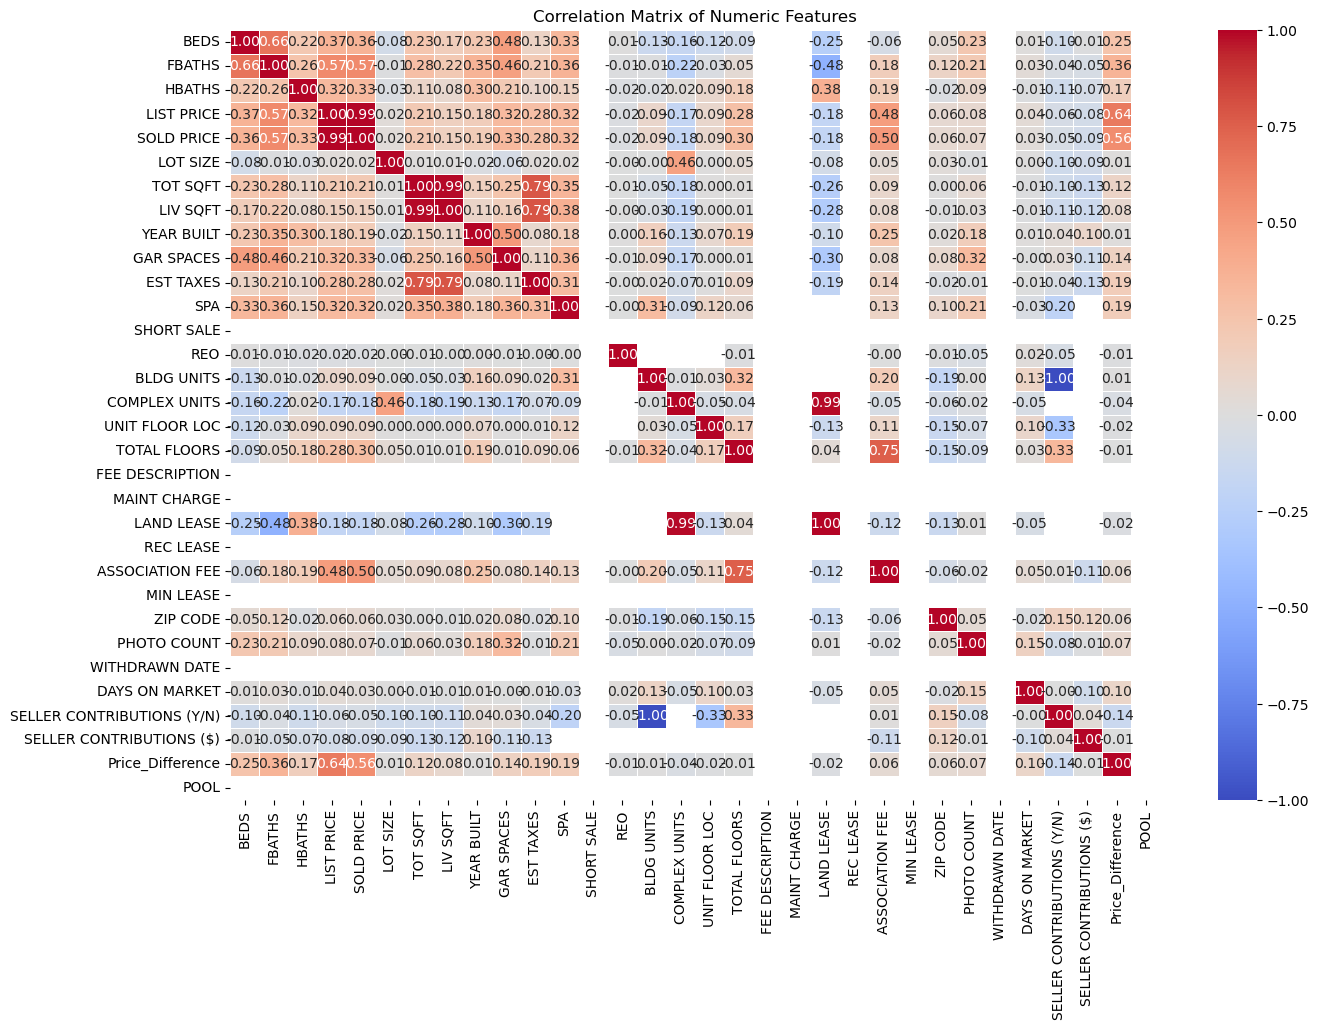

In [220]:

# Select only numeric columns
numeric_columns = data.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


# Step 6: Feature Selection

In [223]:
# Updated feature list based on the available columns
features = ['BEDS', 'FBATHS', 'TOT SQFT', 'LOT SIZE', 'YEAR BUILT', 'POOL1', 'ZIP CODE']
target = 'Price_Difference'

# Check if all features exist in the dataset
missing_features = [feature for feature in features if feature not in data.columns]
if missing_features:
    print("The following features are missing:", missing_features)

# Create feature matrix X and target vector y
X = data[features]
y = data[target]

# Step 7: Train-Test Split

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 8: Build Models

In [229]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


# Step 9: Evaluate Models

In [232]:
# Linear Regression Evaluation
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)
print(f"Linear Regression - RMSE: {lr_rmse}, R²: {lr_r2}")

# Random Forest Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest - RMSE: {rf_rmse}, R²: {rf_r2}")


Linear Regression - RMSE: 103883.36497003413, R²: 0.12112796761008027
Random Forest - RMSE: 95136.06743412874, R²: 0.26290406234589314


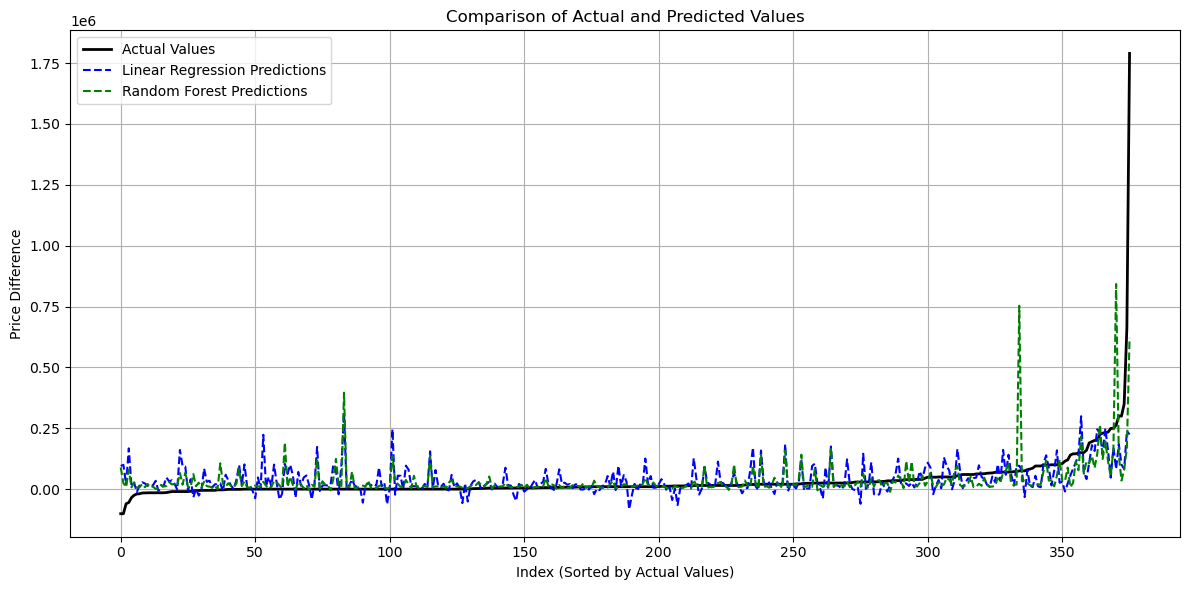

In [234]:
# Sort the test data by actual values for a cleaner comparison plot
sorted_indices = y_test.argsort()
y_test_sorted = y_test.iloc[sorted_indices]
lr_predictions_sorted = lr_predictions[sorted_indices]
rf_predictions_sorted = rf_predictions[sorted_indices]

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(len(y_test_sorted)), y_test_sorted, label='Actual Values', color='black', linewidth=2)

# Plot Linear Regression predictions
plt.plot(range(len(lr_predictions_sorted)), lr_predictions_sorted, label='Linear Regression Predictions', color='blue', linestyle='--')

# Plot Random Forest predictions
plt.plot(range(len(rf_predictions_sorted)), rf_predictions_sorted, label='Random Forest Predictions', color='green', linestyle='--')

# Customize the plot
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index (Sorted by Actual Values)')
plt.ylabel('Price Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Feature Importance

      Feature  Importance
2    TOT SQFT        0.40
4  YEAR BUILT        0.24
6    ZIP CODE        0.13
3    LOT SIZE        0.10
1      FBATHS        0.10
0        BEDS        0.02
5       POOL1        0.01


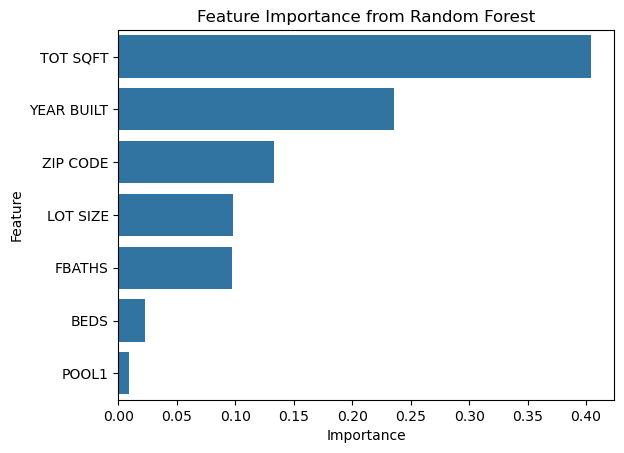

In [237]:
# Feature importance from Random Forest
importance = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Visualize feature importance
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()
